### Suicide Detector

Data source:
https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch/

Data Description:

The dataset is a collection of posts from the "SuicideWatch" and "depression" subreddits of the Reddit platform. The posts are collected using Pushshift API. All posts that were made to "SuicideWatch" from Dec 16, 2008(creation) till Jan 2, 2021, were collected while "depression" posts were collected from Jan 1, 2009, to Jan 2, 2021. All posts collected from SuicideWatch are labeled as suicide, While posts collected from the depression subreddit are labeled as depression. Non-suicide posts are collected from r/teenagers.

The current version has only suicide & non-suicide labels. 

#### Steps Taken:

##### Data Explore and Preprodessing
1. load data, sample data for the purpose of computer power issue
2. Explore the data shape, null value, classes
3. Remove punctuation, remove stop words
4. Map the classes to 0 and 1
5. Find the most common words used for suicide and non-suicide group
##### Create Model, model compile, model training
1. building a model including a embedding layer,a LSTM layer, a dense layer for output
2. complile: use BinaryCrossentropy as loss, accuracy as metrics, Adam as optimizer
##### Model Optimization: Steps taken to overcome overfitting
1. increase data size from 12000 to 50000
2. reduce model complexity (reduce the number of LSTM units from 64 to 16; reduce embedding dimension from 64 to 16
3. Regularization: add l2 regularization to the LSTM layer, value from 0.01 to 0.04, dropout from 0.1 to 0.8; add drop out layers after LSTM layer, value from 0.5 to 0.8
4. Batch Normalization: add batch normalization layers after LSTM layer
5. Early stopping
6. Learning Rate Scheduling (initial lr from 0.01 change to 0.001)

# Data Explore and Preprocessing

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import re

In [2]:
pd.set_option('display.max_colwidth', None)
data = pd.read_csv('Suicide_Detection.csv', index_col = [0])
df = data.sample(n=50000, random_state=42)

In [41]:
# Find the dimension of the df by the attribute 'shape' of df
df.shape

(50000, 2)

In [42]:
# find the column names by the attribute 'colums'
df.columns

Index(['text', 'class'], dtype='object')

In [23]:
df

,text,class
111734,I Don't know?7? Months self harm free and the urge just gets stronger and stronger every day. The past few days I've just been shit... \nMy family stresses me out especially my nephew (he's 12) My mum has full custody of him and he's told me to go kill myself numerous times.. I wish it was that easy.\nMy partners family stresses me out especially over the past few days. \nStress is my trigger \nI just want to scream and cry. \nI live near the woods so I could go out and scream till I can't possibly scream anymore but the cops will probably get called...\nMy OH knows about my depression but he doesn't really know how I'm feeling at the moment. He would want to come over and make sure I'm OK but he's fucking annoying. He annoys me all the time by doing small stupid things. \nI don't even know where I'm going with the post? \n\n,suicide
224358,I HAVE TO START BECOMING RICH I HAVE TO START MY COMPANY SO WHEN I BECOME 16 I CAN AFFORD A BIG VAN AND GO ON TRIPS WITH MY FRIENDS BUT I HAVE NO TIME LEFT I HAVE TO START WORKING,non-suicide
18790,"A poem (haiku) for u/Me-Game-Dev hi, hello hello\nstop fucking saying hello\ni know where you live",non-suicide
21196,"I've honestly got no idea what to do anymore.It feels as if everyone was fake, I feel like I'm backtalked and annoying. I can sometimes like hear my brain speaking to me ''hey.. heyy those people are fake dont talk to them''. So far the only thing that helps is music, but thats kinda stopping to work. I have 2 really fucking good friends and I don't deserve them. Nobody needs a suicidal fucktard who can't help you, who just pushes you away. What use am I to anyone? I barely do anything useful with my life. People say ''what about your loved ones?'' well if I've been fucking abused I don't really think that makes a difference except for my father whos actually fine, out of all my family he is the only one I'd feel about for having to suffer. I don't see a point in hanging on anymore. I'll never get better and I dont want to feel guilty by committing suicide. It is very hard for me to get help and I really don't see how I'm gonna get out of this. I feel like I'm just gonna off myself before I'm even 18. I don't want anyone to feel bad for me, I deserve all of this regardless",suicide
46089,Do you ever just cry? Like you just think about how unfair life is and you just cry? And if you can't cry do you ever just sit there and you can't do anything about it?\n\nLike seriously I'm just sitting here crying because just the world sucks and my life sucks and ugh,non-suicide
...,...,...
22314,You can all go fuck yourselvesShould wait until my birthday on Sun but the whiskey said now is good.\n\nI hate all of you and all your lies.\n\nBeen suffering longer than some of you dumb fucks been aline. Hope you learn just how ba d it can gte.\n\nBYE,suicide
162854,"I dont want to die but I dont want to liveI've rewritten this about 4 times now and I just don't know how to put it into words. The word ""depression"" has seemingly lost its value over the past couple years because it seems like everyone has it now. And whether that's true or not, it's not taken as seriously as it should. I've been dealing with depression and anxiety for about 3 years and I've personally decided I cannot deal with this shit for one more fucking second. Not only does my depression put me in a constant loop of suicidal thoughts and despair, but it also pisses me off. I've had anger issues since I was a little kid and I've been taking meds for them for years and years and years now and those don't seem to helping, so I've been giving this whole thing some thought for quite some time now and I came to the conclusion that I don't understand who I am or what I'm doing here, and for that I don't enjoy life. To be more specific, nothing brings me joy anymore. I don't like video games, I don't like food, I don't like people, I don't like sleeping, I don't like being awake, I don't like my home, I don't like 

In [5]:
# find the unique value of the column 'class'by the method 'unique'
df['class'].unique()

array(['suicide', 'non-suicide'], dtype=object)

In [6]:
# count the unique values in column 'class' by value_counts method
df['class'].value_counts()

class
non-suicide    6029
suicide        5971
Name: count, dtype: int64

In [7]:
# find missing values
df. isnull().sum()

text     0
class    0
dtype: int64

In [3]:
# Function to remove punctuation from a column
def remove_punctuation(text):
    return text.str.replace(r'[^\w\s]', '', regex=True)

# Apply the function to the 'text' column
df['text'] = remove_punctuation(df['text'])

In [9]:
df

,text,class
111734,I Dont know7 Months self harm free and the urge just gets stronger and stronger every day The past few days Ive just been shit \nMy family stresses me out especially my nephew hes 12 My mum has full custody of him and hes told me to go kill myself numerous times I wish it was that easy\nMy partners family stresses me out especially over the past few days \nStress is my trigger \nI just want to scream and cry \nI live near the woods so I could go out and scream till I cant possibly scream anymore but the cops will probably get called\nMy OH knows about my depression but he doesnt really know how Im feeling at the moment He would want to come over and make sure Im OK but hes fucking annoying He annoys me all the time by doing small stupid things \nI dont even know where Im going with the post \n\n,suicide
224358,I HAVE TO START BECOMING RICH I HAVE TO START MY COMPANY SO WHEN I BECOME 16 I CAN AFFORD A BIG VAN AND GO ON TRIPS WITH MY FRIENDS BUT I HAVE NO TIME LEFT I HAVE TO START WORKING,non-suicide
18790,A poem haiku for uMeGameDev hi hello hello\nstop fucking saying hello\ni know where you live,non-suicide
21196,Ive honestly got no idea what to do anymoreIt feels as if everyone was fake I feel like Im backtalked and annoying I can sometimes like hear my brain speaking to me hey heyy those people are fake dont talk to them So far the only thing that helps is music but thats kinda stopping to work I have 2 really fucking good friends and I dont deserve them Nobody needs a suicidal fucktard who cant help you who just pushes you away What use am I to anyone I barely do anything useful with my life People say what about your loved ones well if Ive been fucking abused I dont really think that makes a difference except for my father whos actually fine out of all my family he is the only one Id feel about for having to suffer I dont see a point in hanging on anymore Ill never get better and I dont want to feel guilty by committing suicide It is very hard for me to get help and I really dont see how Im gonna get out of this I feel like Im just gonna off myself before Im even 18 I dont want anyone to feel bad for me I deserve all of this regardless,suicide
46089,Do you ever just cry Like you just think about how unfair life is and you just cry And if you cant cry do you ever just sit there and you cant do anything about it\n\nLike seriously Im just sitting here crying because just the world sucks and my life sucks and ugh,non-suicide
...,...,...
179647,Im trying to start something Hey everyone My name is Sharva and I will be going into high school soon and I made a goal for myself to start a small business and make it successful as I progress throughout school I would really appreciate it if you check out my quick survey I made to start out itll only take 15 minutes If you would not like to take the survey that is completely okay and have a nice day \n\nhttpsformsgleRrc2HggcqUWJaAhe8,non-suicide
66137,Ive lost itI wear a mask At least I used too I wore it for years Im tired of wearing a mask \n\nYea Im gone Hard to believe right No not really Right now you are doing one of two things either asking what you could have done differently or be celebrating \nHonestly you should be celebrating Yay No more having to pretend to like that guy at work I get it Ive seen it youve said it even if you didnt mean to \nFor those of you asking what you could have done differently maybe once asking how I was really doing would have been a great start maybe it wouldnt have helped I dont\nknow remember that mask I talked about earlier yeah that \n\nI loved the work I begged for it pleaded for it daily Work got me through the day with some sort of feeling of accomplishment I could see most didnt care about that\nwork nor did they understand it I get it its fine X doing X things and such I was never looking for the center of attention or all the praise although\nsometimes it may have seemed that way I tried to do what I thought was best s

In [4]:
# remove stop words
import nltk
from nltk.corpus import stopwords

In [5]:
# Download the stopwords
nltk.download('stopwords')

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

# Define a function to remove stop_words
def remove_stopwords(text):
    filtered_words = [word for word in text.split() if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rose2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Apply the function to the 'text' column
df['text'] = df['text'].map(remove_stopwords)

In [14]:
df.iloc[0:1,0]

111734    Dont know7 Months self harm free urge gets stronger stronger every day past days Ive shit family stresses especially nephew hes 12 mum full custody hes told go kill numerous times wish easy partners family stresses especially past days Stress trigger want scream cry live near woods could go scream till cant possibly scream anymore cops probably get called OH knows depression doesnt really know Im feeling moment would want come make sure Im OK hes fucking annoying annoys time small stupid things dont even know Im going post
Name: text, dtype: object

#### Find the most common words used for suicide and non-suicide group

In [83]:
from collections import Counter

In [ ]:
# Define a mapping for unique values
value_mapping = {'suicide': 0, 'non-suicide': 1}

# Use the map function to apply the mapping to the column
df['class'] = df['class'].map(value_mapping)

In [98]:
df_s = df[df['class']==0]

In [107]:
text_s = df_s['text'].str.split().explode()

In [103]:
text_s

array(['Dont', 'know7', 'Months', ..., 'Dave', 'uglyThe', 'correctlyAny'],
      dtype=object)

In [104]:
df_ns = df[df['class']==1]

In [109]:
text_ns = df_ns['text'].str.split().explode()

In [108]:
cnt_s = Counter(text_s).most_common(12)
print(cnt_s)

[('Im', 51235), ('dont', 37740), ('like', 26854), ('want', 26762), ('feel', 22904), ('know', 22552), ('life', 22440), ('Ive', 19159), ('cant', 18754), ('get', 17952), ('even', 15155), ('time', 14691)]


In [110]:
cnt_ns = Counter(text_ns).most_common(12)
print(cnt_ns)

[('Im', 10468), ('like', 10031), ('dont', 6971), ('filler', 6053), ('know', 5142), ('get', 5107), ('people', 4414), ('want', 4252), ('one', 3989), ('really', 3897), ('time', 3389), ('would', 3194)]


In [7]:
text= df['text'].str.split()

In [49]:
type(text)

pandas.core.series.Series

In [8]:
num_unique_words = len(text.explode().unique())
num_unique_words

101134

In [45]:
cnt = Counter(text).most_common(12)
print(cnt)

[('Im', 7406), ('dont', 5455), ('like', 4540), ('want', 3702), ('know', 3439), ('feel', 3157), ('get', 2858), ('life', 2852), ('cant', 2708), ('Ive', 2576), ('people', 2210), ('would', 2169)]


## Building Model

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split (df['text'],df['class'],test_size = 0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split (X_train, y_train, test_size = 0.2,random_state=1)

In [12]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(36000,) (36000,) (9000,) (9000,) (5000,) (5000,)


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
# vectorized a text corpus by turning each word to a sequence of integer
tok = Tokenizer(num_words=num_unique_words)
tok.fit_on_texts(X_train)

In [54]:
# get the word_index, each word has a index
word_index = tok.word_index

In [55]:
word_index

{'im': 1,
 'dont': 2,
 'like': 3,
 'want': 4,
 'know': 5,
 'feel': 6,
 'life': 7,
 'ive': 8,
 'get': 9,
 'cant': 10,
 'people': 11,
 'even': 12,
 'one': 13,
 'time': 14,
 'would': 15,
 'really': 16,
 'think': 17,
 'going': 18,
 'go': 19,
 'never': 20,
 'friends': 21,
 'much': 22,
 'day': 23,
 'help': 24,
 'years': 25,
 'things': 26,
 'got': 27,
 'make': 28,
 'good': 29,
 'fucking': 30,
 'anything': 31,
 'school': 32,
 'could': 33,
 'someone': 34,
 'way': 35,
 'anymore': 36,
 'back': 37,
 'still': 38,
 'see': 39,
 'fuck': 40,
 'something': 41,
 'need': 42,
 'everything': 43,
 'didnt': 44,
 'always': 45,
 'better': 46,
 'family': 47,
 'nothing': 48,
 'filler': 49,
 'every': 50,
 'die': 51,
 'anyone': 52,
 'love': 53,
 'end': 54,
 'talk': 55,
 'live': 56,
 'kill': 57,
 'year': 58,
 'ill': 59,
 'right': 60,
 'suicide': 61,
 'ever': 62,
 'say': 63,
 'shit': 64,
 'hate': 65,
 'work': 66,
 'last': 67,
 'take': 68,
 'everyone': 69,
 'thing': 70,
 'since': 71,
 'person': 72,
 'bad': 73,
 'paren

In [71]:
# get the sequence for taining and validation dataset
X_train_seq = tok.texts_to_sequences(X_train)
X_val_seq = tok.texts_to_sequences(X_val)
X_test_seq = tok.texts_to_sequences(X_test)

In [25]:
print(X_train_seq[0:1]) # index for each words
print(X_train.iloc[0:1]) # words

[[211, 840, 166, 17, 2, 211, 13817, 112, 893, 211, 13818, 3, 39, 107]]
322075    call teachers US think dont call forenames maybe title call sirmiss like something else
Name: text, dtype: object


In [72]:
# pad the sequence to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 20

X_train_padded = pad_sequences(X_train_seq,maxlen=max_len, padding='post',truncating='post')
X_val_padded = pad_sequences(X_val_seq,maxlen=max_len, padding='post',truncating='post')
X_test_padded = pad_sequences(X_test_seq,maxlen=max_len, padding='post',truncating='post')

X_train_padded.shape, X_val_padded.shape, X_test_padded.shape

((36000, 20), (9000, 20), (5000, 20))

In [27]:
print (X_train_padded[0],X_train_seq[0],X_train.iloc[0])

[  211   840   166    17     2   211 13817   112   893   211 13818     3
    39   107     0     0     0     0     0     0] [211, 840, 166, 17, 2, 211, 13817, 112, 893, 211, 13818, 3, 39, 107] call teachers US think dont call forenames maybe title call sirmiss like something else


In [67]:
# Create Model

from tensorflow.keras import layers
from keras.regularizers import l2
from keras.layers import BatchNormalization,Dropout


model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words,16,input_length=max_len))# embedding dimenstion 64-32-16
model.add(layers.LSTM(16,dropout=0.8,kernel_regularizer=l2(0.04)))# 64-32-16; dropout 0.5-0,8;l2(0.01-0.03-0.04) added to fix overfitting
model.add(BatchNormalization())  # Add BatchNormalization to fix overfitting
model.add(Dropout(0.8))  # Add Dropout after the BatchNormalization to fic overfitting
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 20, 16)            1618144   
                                                                 
 lstm_11 (LSTM)              (None, 16)                2112      
                                                                 
 batch_normalization_8 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,620,337
Trainable params: 1,620,305
Non-trainable params: 32
__________________________________________

In [68]:
loss = keras.losses.BinaryCrossentropy(from_logits =False)
optim = keras.optimizers.Adam(learning_rate=0.001)#lr0.01-0.001
metrics =['accuracy']

model.compile(loss=loss, optimizer=optim,metrics=metrics)

In [69]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=10,          
                               restore_best_weights=True)  # Restore model weights to the best seen during training

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)# factor 0.2-0.5

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_suicideDet_checkpoint.h5', save_best_only=True)

In [70]:
hist = model.fit(X_train_padded, y_train, epochs=1000, validation_data=(X_val_padded,y_val),verbose=2,callbacks=[early_stopping, lr_schedule,checkpoint_callback])

Epoch 1/1000
1125/1125 - 27s - loss: 0.5881 - accuracy: 0.7836 - val_loss: 0.3539 - val_accuracy: 0.8467 - lr: 0.0010 - 27s/epoch - 24ms/step
Epoch 2/1000
1125/1125 - 24s - loss: 0.3443 - accuracy: 0.8682 - val_loss: 0.5214 - val_accuracy: 0.7831 - lr: 0.0010 - 24s/epoch - 21ms/step
Epoch 3/1000
1125/1125 - 24s - loss: 0.3105 - accuracy: 0.8849 - val_loss: 0.2613 - val_accuracy: 0.8972 - lr: 0.0010 - 24s/epoch - 21ms/step
Epoch 4/1000
1125/1125 - 24s - loss: 0.2868 - accuracy: 0.8921 - val_loss: 0.3107 - val_accuracy: 0.8742 - lr: 0.0010 - 24s/epoch - 22ms/step
Epoch 5/1000
1125/1125 - 24s - loss: 0.2735 - accuracy: 0.8999 - val_loss: 0.6194 - val_accuracy: 0.7340 - lr: 0.0010 - 24s/epoch - 22ms/step
Epoch 6/1000
1125/1125 - 24s - loss: 0.2581 - accuracy: 0.9040 - val_loss: 0.2988 - val_accuracy: 0.8818 - lr: 0.0010 - 24s/epoch - 21ms/step
Epoch 7/1000
1125/1125 - 24s - loss: 0.2450 - accuracy: 0.9117 - val_loss: 0.2246 - val_accuracy: 0.9116 - lr: 2.0000e-04 - 24s/epoch - 22ms/step
Ep

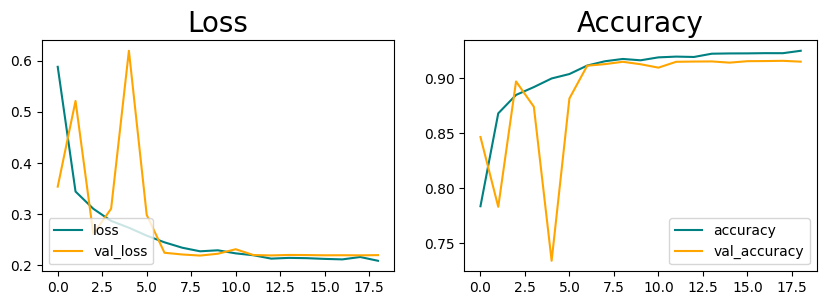

In [73]:
# Create a scatter plot for the Loss and Accuracy across the training process
fig,ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(hist.history['loss'],color='teal',label='loss')
ax[0].plot(hist.history['val_loss'],color='orange',label='val_loss')
ax[0].set_title('Loss',fontsize=20)
ax[0].legend(loc='lower left')

ax[1].plot(hist.history['accuracy'],color='teal',label='accuracy')
ax[1].plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
ax[1].set_title('Accuracy',fontsize=20)
ax[1].legend(loc='lower right')
plt.show()

In [74]:
# make prediction
pred = model.predict(X_train_padded)
pred = [1 if p>0.5 else 0 for p in pred]

1125/1125 [==============================] - 5s 4ms/step


In [77]:
print(X_train.iloc[0:5])
print(y_train.iloc[0:5])
print(pred[0:5])

192098    Staying AliveI beautiful family Two kids loving wife know screwed leave dont want stay sick 8 treatments ECT nothing Meds helping Therapy helping could Id lobotomized Last night dream finding gun kill want write suicide note dont know start Im literally trapped years life wont allow hospitalized feeling even trapped kids wife better without deserve better Ive told wife want find someone better Someone doesnt ask constantly wrong
1554                                                                                                                                                                                                                                                                                                                                                                                                              good night im terribly miserable bye bye
172397                                                                                                            

# Evaluation

In [78]:
from tensorflow.keras.metrics import Precision, Recall,Accuracy,AUC
from sklearn.metrics import confusion_matrix

In [79]:
y_pred = model.predict(X_test_padded)
y_pred = [1 if p>0.5 else 0 for p in y_pred]

157/157 [==============================] - 1s 4ms/step


In [80]:
pre = Precision()
re = Recall()
acc = Accuracy()
auc = AUC()

In [81]:
pre.update_state(y_test, y_pred)
re.update_state(y_test, y_pred)
acc.update_state(y_test, y_pred)
auc.update_state(y_test,y_pred)

In [82]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, AUC: {auc.result().numpy()}')

Precision: 0.9155206084251404, Recall: 0.9220419526100159, Accuracy: 1.0, AUC: 0.9175515174865723
